In [36]:
import numpy as np
import pandas as pd
pd.options.display.width = 400
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.linear_model import LinearRegression

In [64]:
def orthogonalize_to_single_vector(y, x):
    """Orthogonalize y to x"""    
    beta = np.cov(y, x)[0, 1] / np.cov(x, x)[0, 1]
    y_ort = y - x * beta
    return y_ort

def ortogonalize_to_multiple_vectors(y, X):
    """Orthogonalize y to columns of X"""
    if X.shape[1] == 0:
        return y
    reg = LinearRegression()
    reg.fit(X, y)
    y_ort = y - reg.predict(X)
    assert np.abs(y_ort.sum()) < 1e-4, "sum of errors must be zero"
    return y_ort
    

def compute_pacf_1(y, x, Z):
    """using LinearRegression"""
    y_ort = ortogonalize_to_multiple_vectors(y, Z)
    x_ort = ortogonalize_to_multiple_vectors(x, Z)
    res = np.corrcoef(x_ort, y_ort)[0, 1]
    return res

def compute_pacf_2(y, x, Z):
    """using Gram-Schmidt"""
    Z = Z.copy()
    y_ort = y
    x_ort = x
    M = len(Z.columns)
    for i in range(M):
        z = Z[Z.columns[i]]
        for j in range(i+1, M):
            Z[Z.columns[j]] = orthogonalize_to_single_vector(Z[Z.columns[j]], z)
        y_ort = orthogonalize_to_single_vector(y_ort, z)
        x_ort = orthogonalize_to_single_vector(x_ort, z)
    return np.corrcoef(x_ort, y_ort)[0, 1]

def compute_pacf_3(y, x, Z):
    """using LinearRegression"""
    reg = LinearRegression()
    X = pd.concat([Z, x], axis='columns')
    reg.fit(X, y)
    return reg.coef_[-1]


#pacf(df["x4"], df["x1"], [df["x2"]])

    acf_lib  pacf_lib  acf_lib_from_X  pacf_lib_from_X''  pacf_my_1  pacf_my_2  pacf_my_3
0      1.00      1.00            1.00               1.00       1.00       1.00       1.00
1      0.64      0.64            0.64               0.64       0.64       0.64       0.64
2     -0.14     -0.94           -0.15              -0.94      -0.93      -0.93      -0.94
3     -0.78     -0.10           -0.79              -0.10      -0.11      -0.11      -0.11
4     -0.81      0.39           -0.82               0.38       0.36       0.36       0.36
5     -0.26     -0.18           -0.26              -0.19      -0.17      -0.17      -0.17
6      0.45     -0.09            0.45              -0.09      -0.08      -0.08      -0.08
7      0.78      0.11            0.79               0.11       0.09       0.09       0.09
8      0.54     -0.01            0.54              -0.01      -0.01      -0.01      -0.01
9     -0.08     -0.06           -0.08              -0.06      -0.05      -0.05      -0.05
10    -0.6

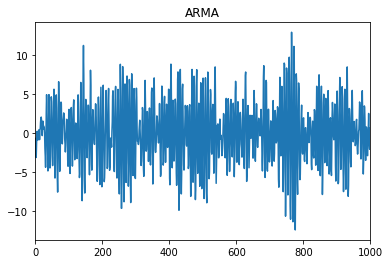

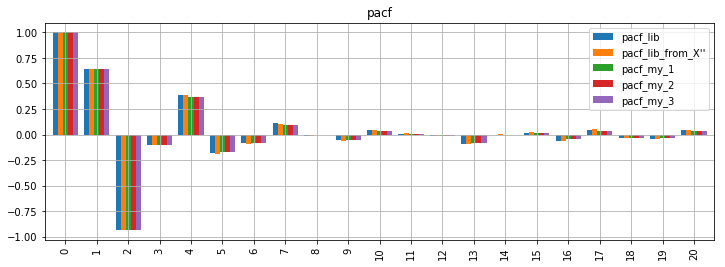

In [66]:
LAGS=20
x = pd.Series(arma_generate_sample([1, -0.7, 0.3, 0.5], [1, 0.5, 0.4], nsample=1000, sigma=1,))
x.plot(title="ARMA")

df = pd.DataFrame({
    "acf_lib":  acf(x, nlags=LAGS),
    "pacf_lib": pacf(x, nlags=LAGS),
})

# prepare matrix of lagged x
X = pd.DataFrame()
for lag in range(LAGS+1):
    X[lag] = x.shift(lag)
X = X.dropna()

df["acf_lib_from_X"] = acf(X[0], nlags=LAGS)
df["pacf_lib_from_X''"] = pacf(X[0], nlags=LAGS)


my_acf = []
my_pacf_1 = []
my_pacf_2 = []
my_pacf_3 = []

for lag in range(LAGS+1):
#    print X.sum().sum()
    my_acf.append(np.corrcoef(X[0], X[lag])[0,1])
    Z = X[[l for l in range(1, lag)]]
    my_pacf_1.append(compute_pacf_1(X[0], X[lag], Z))
    my_pacf_2.append(compute_pacf_2(X[0], X[lag], Z))
    my_pacf_3.append(compute_pacf_3(X[0], X[lag], Z))

    
#df["acf_my"] = my_acf
df["pacf_my_1"] = my_pacf_1
df["pacf_my_2"] = my_pacf_2
df["pacf_my_3"] = my_pacf_3


#df[[col for col in df.columns if col.startswith('acf')]].plot(title='acf', kind='bar', width=0.8, grid=True, figsize=(12, 4))
df[[col for col in df.columns if col.startswith('pacf')]].plot(title='pacf', kind='bar', width=0.8, grid=True, figsize=(12, 4))

print df.to_string(float_format="{:.2f}".format)
# #plt.plot(statsmodels.graphics.tsaplots.pacf(x))
# f = plt.figure(figsize=(4,6))
# axs = f.subplots(2,1)

# statsmodels.graphics.tsaplots.plot_acf(x, lags=LAGS, ax=axs[0])
# df['acf'].plot(kind='bar', ax=axs[0], color='g')

# statsmodels.graphics.tsaplots.plot_pacf(x, lags=LAGS, ax=axs[1])
# df['pacf'].plot(kind='bar', ax=axs[1], color='g')

# for ax in axs:
#     ax.set_yticks(np.linspace(0, 1, 11))
#     ax.grid()
# f.tight_layout()
# pass
# #plt.acorr(x)

In [10]:
np.cov

> /Users/mshevelev/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py(64)_evaluate_standard()
     62         _store_test_result(False)
     63     with np.errstate(all='ignore'):
---> 64         return op(a, b)
     65 
     66 

> /Users/mshevelev/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py(122)_evaluate_numexpr()
    120 
    121     if result is None:
--> 122         result = _evaluate_standard(op, op_str, a, b, raise_on_error)
    123 
    124     return result

> /Users/mshevelev/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py(211)evaluate()
    209     if use_numexpr:
    210         return _evaluate(op, op_str, a, b, raise_on_error=raise_on_error,
--> 211                          **eval_kwargs)
    212     return _evaluate_standard(op, op_str, a, b, raise_on_error=raise_on_error)
    213 

> /Users/mshevelev/anaconda2/lib/python2.7/site-packages/pandas/core/ops.py(674)na_op()
    672        

In [5]:
if False:
    x = np.array([2., 4., 15., 20])
    y = np.array([1., 2., 3., 4.])
    z = np.array([0., 0., 1., 1.])
    z = np.array([0., 0., 1., 1.])

    df = pd.DataFrame({"x": x, "y": y, "z": z})

In [26]:
def sample_mv_gaussian(n_samples, mu, C):
    assert len(mu) == C.shape[0] == C.shape[1]
    m_variables = len(mu)
    L = np.linalg.cholesky(C)
    z = np.random.randn(m_variables, n_samples)
    res = mu + np.dot(L, z).T
    return res


def cov_to_corr(C):
    d = np.sqrt(np.diag(C))
    C_corr = C / (d * d[:, None])
    return C_corr
    

In [48]:
np.set_printoptions(precision=4, linewidth=300)
C = np.random.randn(4,4)
C = np.dot(C.T, C)
print "cov:\n",C
d = np.sqrt(np.diag(C))
C_corr = C / (d * d[:, None])
print "corr:\n", C_corr



cov:
[[ 3.0066  0.9122 -2.3575  0.7327]
 [ 0.9122  1.4582 -2.536   0.4099]
 [-2.3575 -2.536   6.0499  0.3271]
 [ 0.7327  0.4099  0.3271  2.1997]]
corr:
[[ 1.      0.4356 -0.5528  0.2849]
 [ 0.4356  1.     -0.8538  0.2288]
 [-0.5528 -0.8538  1.      0.0897]
 [ 0.2849  0.2288  0.0897  1.    ]]


In [49]:
X = sample_mv_gaussian(1000, mu=10 * np.random.randn(C.shape[0]), C=cov_to_corr(C))
df = pd.DataFrame(X, columns=["x1", "x2", "x3", "x4"])
df.head()

,x1,x2,x3,x4
0,-0.393272,-15.484311,-11.412935,-9.844738
1,-0.414403,-17.362706,-11.268046,-10.472452
2,0.992308,-13.387772,-14.665082,-9.164141
3,-0.925878,-16.230206,-11.018061,-7.847344
4,-1.409223,-14.710290,-11.382047,-8.800754


In [50]:
df.cov()

,x1,x2,x3,x4
x1,1.034794,0.455051,-0.604770,0.264017
x2,0.455051,1.019197,-0.892319,0.233057
x3,-0.604770,-0.892319,1.056453,0.075005
x4,0.264017,0.233057,0.075005,1.003494


In [51]:
reg = LinearRegression()

In [52]:
reg.fit(df[["x1", "x2"]], df["x4"])
print reg.coef_



[ 0.1923  0.1428]


In [53]:
def pacf(y, x, z_list):
    eps_y = y
    eps_x = x
    reg = LinearRegression()
    for z in z_list:
        X = z.reshape((len(z), 1))
        reg.fit(X, eps_y)
        eps_y = eps_y - reg.predict(X)
        reg.fit(X, eps_x)
        eps_x = eps_x - reg.predict(X)
    return np.cov(eps_y, eps_x)

pacf(df["x4"], df["x1"], [df["x2"]])

/Users/mshevelev/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([[ 0.9502,  0.16  ],
       [ 0.16  ,  0.8316]])

In [34]:
df

,x,y,z
0,2.0,1.0,0.0
1,4.0,2.0,0.0
2,15.0,3.0,1.0
3,20.0,4.0,1.0


In [24]:
reg = LinearRegression()

In [36]:
reg.fit(df[['z']], df['x'])
x_ort = df['x'] - reg.predict(df[['z']])
x_ort 

0   -1.0
1    1.0
2   -2.5
3    2.5
Name: x, dtype: float64

In [37]:
reg.fit(df[['z']], df['y'])
y_ort = df['y'] - reg.predict(df[['z']])
y_ort 

0   -0.5
1    0.5
2   -0.5
3    0.5
Name: y, dtype: float64

In [38]:
print np.corrcoef(x, y)[0, 1]
print np.corrcoef(x_ort, y_ort)[0, 1]

0.969501551921
0.919145030018


In [ ]:
np.linalg.lstsq()